# Radon example from Gelman and Hill (2006)
This is a reworking of the radon example from pymc3 https://docs.pymc.io/notebooks/multilevel_modeling.html


Other implementations in: 

- tensorflow https://www.tensorflow.org/probability/examples/Multilevel_Modeling_Primer - pymc3 https://docs.pymc.io/notebooks/multilevel_modeling.html 

- stan https://mc-stan.org/users/documentation/case-studies/radon.html 

- pyro https://github.com/pyro-ppl/pyro-models/blob/master/pyro_models/arm/radon.py 

- numpyro fibrosis dataset http://num.pyro.ai/en/stable/tutorials/bayesian_hierarchical_linear_regression.html

In [1]:
import altair as alt
alt.renderers.enable('altair_saver', fmts=['png'])
from bayes_window import BayesWindow
from bayes_window.utils import load_radon
df = load_radon()

df

,county,radon,floor
0,AITKIN,2.2,1
1,AITKIN,2.2,0
2,AITKIN,2.9,0
3,AITKIN,1.0,0
4,ANOKA,3.1,0
...,...,...,...
922,WRIGHT,6.4,0
923,WRIGHT,4.5,0
924,WRIGHT,5.0,0
925,YELLOW MEDICINE,3.7,0


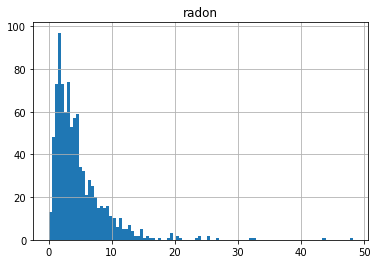

In [2]:
df.set_index(['county','floor']).hist(bins=100);

In [3]:
window=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')

## Plot data

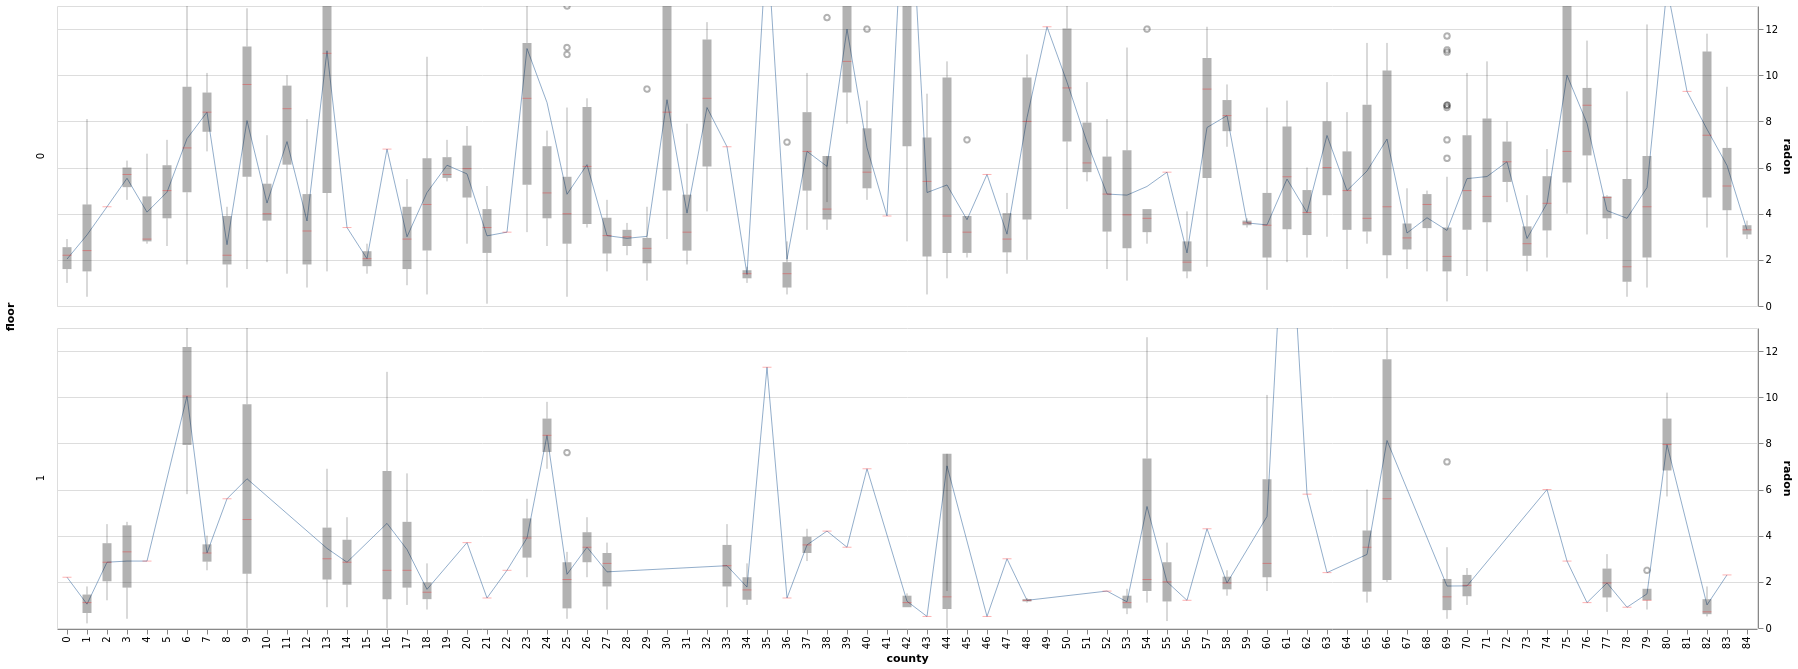

In [4]:
window.plot(x='county').facet(row='floor')

## Fit LME

Using formula radon ~  C(floor, Treatment) + (1 | county)
                           Coef. Std.Err.       z  P>|z|  [0.025  0.975]
Intercept                  5.493    0.525  10.464  0.000   4.464   6.522
C(floor, Treatment)[T.1]  -2.289    0.388  -5.899  0.000  -3.050  -1.529
1 | county                 0.005    0.011   0.450  0.653  -0.016   0.025
Group Var                  2.852    0.207                               


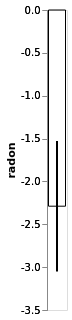

In [5]:
window.fit_lme()#formula='radon ~ floor + ( 1 | county)')

window.plot()

## Fit Bayesian hierarchical with and without county-specific intercept

Uneven number of entries in conditions! This will lead to nans in data (window.data["radon diff"(255, 180)


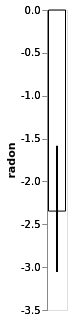

In [6]:
window1=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')
window1.fit_slopes(add_group_intercept=True);
window1.plot()

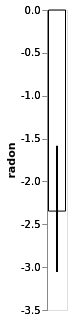

In [7]:
window1.plot(x=':O')

### Inspect intercepts (horizontal ticks)

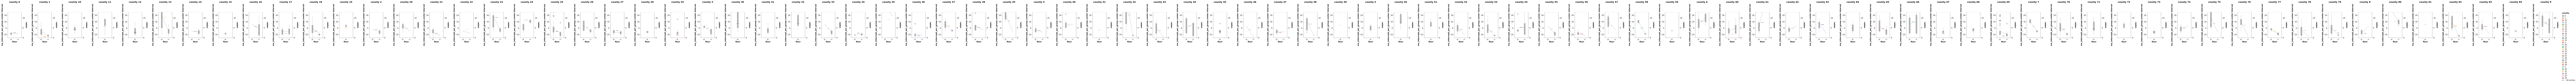

In [8]:
window1.plot_slopes_intercepts()

Uneven number of entries in conditions! This will lead to nans in data (window.data["radon diff"(255, 180)


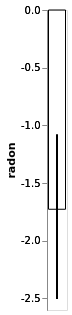

In [9]:
window2=BayesWindow(df.reset_index(), y='radon', treatment='floor',group='county')
window2.fit_slopes(add_group_intercept=False, add_group_slope=False, do_make_change='subtract');
window2.plot()

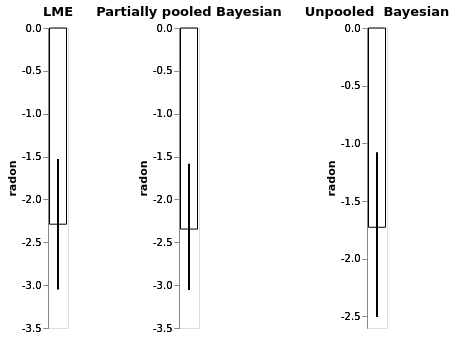

In [10]:
(window.plot().properties(title='LME')|
 window1.plot().properties(title='Partially pooled Bayesian')|
 window2.plot().properties(title='Unpooled  Bayesian'))

## Compare the two models

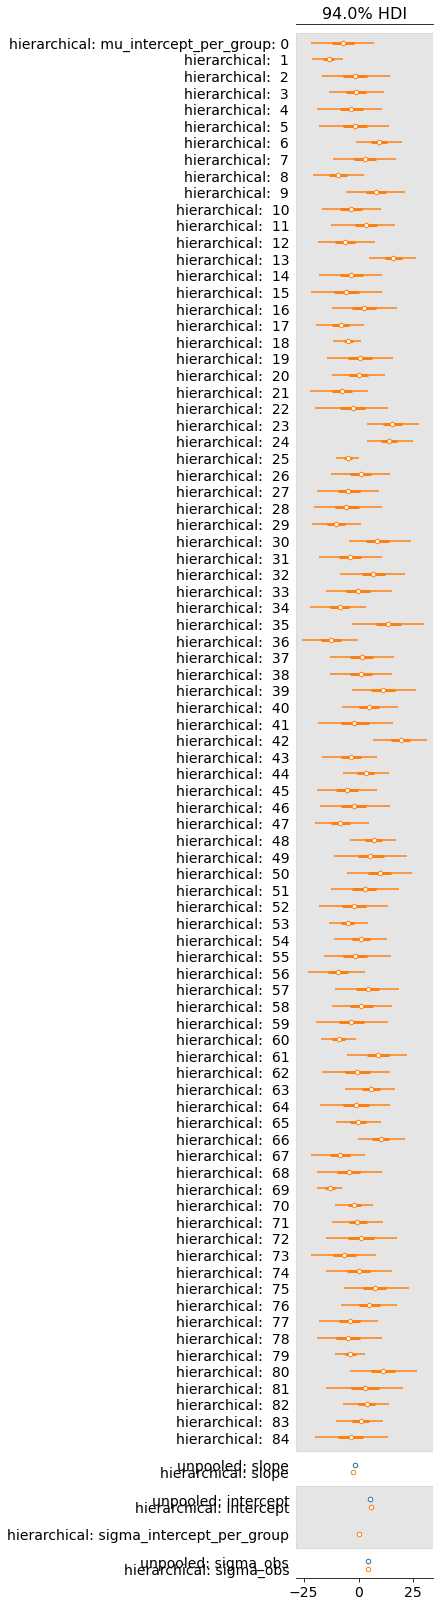

In [11]:
import arviz as az
datasets = {'unpooled' : window2.trace.posterior,
           'hierarchical': window1.trace.posterior} 

az.plot_forest(data=list(datasets.values()), model_names=list(datasets.keys()), 
               #backend='bokeh',
               #kind='ridgeplot',
               #ridgeplot_overlap=1.6,
               combined=True);



For leave-one-out, let's remove any counties that did not contain both floors. This drops about 250 rows

In [12]:
import pandas as pd
df_clean = pd.concat([ddf for i, ddf in df.groupby(['county']) 
                      if (ddf.floor.unique().size>1) 
                      and (ddf[ddf['floor']==0].shape[0]>1)
                      and (ddf[ddf['floor']==1].shape[0]>1)
                     ])


df_clean

,county,radon,floor
4,ANOKA,3.1,0
5,ANOKA,2.5,0
6,ANOKA,1.5,0
7,ANOKA,1.0,0
8,ANOKA,0.7,0
...,...,...,...
907,WINONA,10.2,0
908,WINONA,11.3,0
909,WINONA,7.6,0
910,WINONA,11.8,0


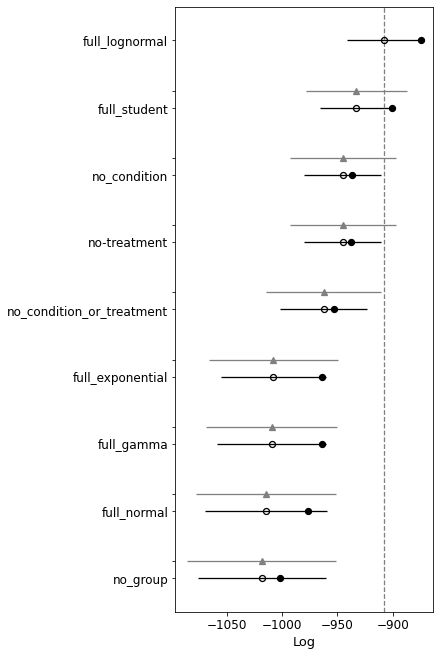

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
full_lognormal,0,-907.806743,33.793694,0.000000,5.985783e-01,33.157691,0.000000,True,log
full_student,1,-932.957605,31.881710,25.150862,2.344203e-01,32.476757,45.784109,True,log
no_condition,2,-945.199396,8.350979,37.392653,4.083982e-02,34.749153,48.012673,False,log
no-treatment,3,-945.280752,7.908689,37.474010,4.023297e-02,34.907375,48.039980,True,log
no_condition_or_treatment,4,-962.578833,9.697075,54.772090,8.592858e-02,39.271098,52.368182,False,log
full_exponential,5,-1007.829080,43.867355,100.022337,0.000000e+00,47.746346,58.269645,True,log
full_gamma,6,-1009.557619,46.028121,101.750876,0.000000e+00,49.495827,59.532526,True,log
full_normal,7,-1014.587069,37.688251,106.780326,4.426200e-13,54.870124,63.606261,True,log
no_group,8,-1018.466110,16.997491,110.659368,1.710297e-10,57.805544,67.474282,True,log


In [13]:
window1.data=df_clean
window1.explore_models()

It looks like using including intercept actually hurts leave-one-out posterior predictive. Actually, so does including floor in the model. To bring this home, let's only use the models that did not have a warning above:

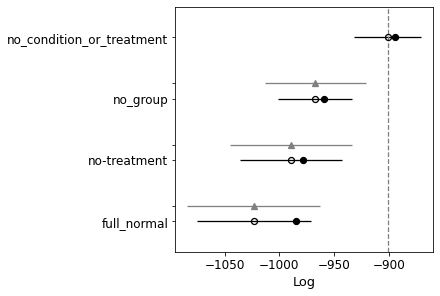

,rank,loo,p_loo,d_loo,weight,se,dse,warning,loo_scale
no_condition_or_treatment,0,-900.773165,6.262986,0.000000,7.635278e-01,30.714123,0.000000,False,log
no_group,1,-967.380955,8.288646,66.607790,2.364722e-01,33.997148,46.274120,False,log
no-treatment,2,-989.439490,11.195735,88.666325,0.000000e+00,46.266788,55.431760,True,log
full_normal,3,-1023.643999,38.800391,122.870834,6.180612e-13,52.056894,60.920011,True,log


In [15]:
from bayes_window.model_comparison import compare_models

compare_models(df_clean,y=window1.y,parallel=True,
    models = {
                'full_normal': window1.model,
                'no_condition_or_treatment': window1.model,
                'no-treatment': window1.model,
                'no_group': window1.model,
            },
            extra_model_args = [
                {'treatment': window1.treatment, 'group': window1.group},
                {'treatment': None, 'condition': None},
                {'treatment': None, 'condition': window1.condition},
                {'treatment': window1.treatment, 'group': None},
            ])

Keep in mind though that we had to remove some data that had too few labels in order to make LOO work. 

## References

  -  Gelman, A., & Hill, J. (2006), Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.), Cambridge University Press.
  -  Gelman, A. (2006), Multilevel (Hierarchical) modeling: what it can and cannot do, Technometrics, 48(3), 432–435.
  -  McElreath, R. (2020), Statistical Rethinking - A Bayesian Course with Examples in R and Stan (2nd ed.), CRC Press.

